In [1]:
import pandas as pd

df=pd.read_excel('C:/Users/vikra/.spyder-py3/CMC Database.xlsx', sheet_name = 'Sheet4', header=0)

print(df)

     Serial No.  Surfactant No.        Charge           Surfactant Name  \
0             1             1.0       Anionic  Sodium Dodecyl 1 Sulfate   
1             2             NaN       Anionic  Sodium Dodecyl 1 Sulfate   
2             3             2.0       Anionic    Sodium Octyl 1 Sulfate   
3             4             NaN       Anionic    Sodium Octyl 1 Sulfate   
4             5             3.0       Anionic    Sodium Decyl 1 Sulfate   
..          ...             ...           ...                       ...   
262         263           256.0  Zwitterionic  C12H25N+(CH3)2(CH2)5COO−   
263         264           257.0  Zwitterionic  C12H25N+(CH3)2(CH2)7COO−   
264         265           258.0  Zwitterionic     C8H17CH(COO-)N+(CH3)3   
265         266           259.0  Zwitterionic    C10H21CH(COO-)N+(CH3)3   
266         267           260.0  Zwitterionic    C12H25CH(COO-)N+(CH3)3   

    Formula                   Head Group  \
0       NaN                      Sulfate   
1       NaN

In [2]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Serial No.,267.0,134.000000,77.220464,1.000000,67.500000,134.000000,200.500000,267.000000
Surfactant No.,260.0,130.500000,75.199734,1.000000,65.750000,130.500000,195.250000,260.000000
Temp (oC),267.0,24.194757,1.855567,20.000000,25.000000,25.000000,25.000000,27.000000
CMC (M),267.0,0.028556,0.098809,0.000002,0.000335,0.003100,0.015950,0.910000
-log CMC,267.0,2.651781,1.212071,0.040959,1.797241,2.508638,3.474955,5.795880
2^-log(CMC),267.0,49.369483,94.124788,1.046025,7.202820,15.737098,45.496185,582.555821


In [3]:
# Identify target column (output). For this example, wine quality is the target property
target = ['-log CMC']
# Identify features (inputs)
features = (list(set(list(df.columns))-set(target)))
# Print features
features

['Head Group',
 'Surfactant Name',
 'Charge',
 '2^-log(CMC)',
 'CMC (M)',
 'Formula',
 'Surfactant No.',
 'Serial No.',
 'Temp (oC)',
 'SMILES Representation']

In [4]:
headers = df.columns.tolist()
headers

['Serial No.',
 'Surfactant No.',
 'Charge',
 'Surfactant Name',
 'Formula',
 'Head Group',
 'SMILES Representation',
 'Temp (oC)',
 'CMC (M)',
 '-log CMC',
 '2^-log(CMC)']

In [5]:

df2 = df.drop(df.columns[[0,1,2,3,4,5,8,10]], axis= 1)
df2 = df2.drop([28,29,51])


#df2 = df2.loc[130:135, :]
df2 = df2.reset_index()
df2 = df2.drop(['index'], axis= 1)

df2

,SMILES Representation,Temp (oC),-log CMC
0,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],20,2.072117
1,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],25,2.080922
2,CCCCCCCCOS(=O)(=O)[O-].[Na+],20,0.873869
3,CCCCCCCCOS(=O)(=O)[O-].[Na+],25,0.885056
4,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],20,1.474955
...,...,...,...
259,CCCCCCCCCCCC[N+](C)(C)CCCCCC(=O)[O-],25,2.585027
260,CCCCCCCCCCCC[N+](C)(C)CCCCCCCC(=O)[O-],25,2.823909
261,CCCCCCCCC(C(=O)[O-])[N+](C)(C)C,27,1.013228
262,CCCCCCCCCCC(C(=O)[O-])[N+](C)(C)C,27,1.886057


In [6]:
#Checks to see if there is any null values within each of the columns of the database.
df2.isnull().sum()

SMILES Representation    0
Temp (oC)                0
-log CMC                 0
dtype: int64

In [7]:
import numpy as np
import rdkit as rd
from rdkit import Chem, DataStructs, rdBase
#draw the molecules
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AtomPairs
from rdkit.Chem.AtomPairs.Pairs import GetAtomPairFingerprintAsBitVect

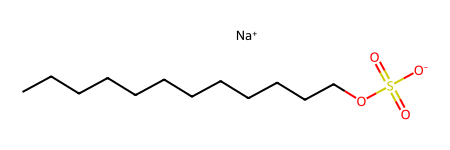

In [8]:
smile = df2.iloc[0,0]
mol = Chem.MolFromSmiles(smile)
mol

In [9]:
#Create a function that will convert the smiles into a morgan fingerprint
def MoleculeGen(rad: int, dataframe: pd.DataFrame) -> pd.DataFrame:
    #initilise empty lists for holding the mol drawings and morgan fingerprints
    mol_list = []
    fin_list = []
    i = 0
    
    for smile in dataframe['SMILES Representation']:
        i += 1
        try:
            #Generate the molecular drawing of the smile
            mol = Chem.MolFromSmiles(smile)
            mol_list.append(mol)
            #Generate the morgan fingerprint of the smile in question
            mf_bitvect = AllChem.GetMorganFingerprintAsBitVect(mol, radius= rad, nBits= 2**10)
            #initialise a temporary array that will have the bit vector mapped onto to convert from bit vector to numpy array\
            #(this is because we can only use np arrays and not bit vectors within python)
            temp = np.zeros((0,), dtype= np.int8)
            DataStructs.ConvertToNumpyArray(mf_bitvect, temp)
            fin_list.append(temp)
           
        except:
            print(i, smile)
    #convert the np array to a dataframe that we can then add to the main dataframe in question
    fin_list = pd.DataFrame(fin_list)
    #Add the fingerprint list to the main dataframe along the columns (axis = 1)
    dataframe = pd.concat([dataframe, fin_list], axis= 1)
    return dataframe

In [10]:
#Call the function to generate the fingerprints
df3 = MoleculeGen(7, df2)



df3

[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerat

[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator


,SMILES Representation,Temp (oC),-log CMC,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],20,2.072117,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],25,2.080922,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,CCCCCCCCOS(=O)(=O)[O-].[Na+],20,0.873869,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,CCCCCCCCOS(=O)(=O)[O-].[Na+],25,0.885056,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],20,1.474955,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,CCCCCCCCCCCC[N+](C)(C)CCCCCC(=O)[O-],25,2.585027,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260,CCCCCCCCCCCC[N+](C)(C)CCCCCCCC(=O)[O-],25,2.823909,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
261,CCCCCCCCC(C(=O)[O-])[N+](C)(C)C,27,1.013228,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
262,CCCCCCCCCCC(C(=O)[O-])[N+](C)(C)C,27,1.886057,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [11]:
output = df3['-log CMC']
features = df3.drop(['-log CMC', 'SMILES Representation'], axis=1)
x_data = features.values
y_data = output.values

In [12]:
# Import scikit learn classifier and regressor.
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import numpy as np

# Tool for splitting sets. Needed to split training and test data
from sklearn.model_selection import train_test_split

# Module to normalized data
from sklearn import preprocessing

# Tool for calculation of the mean square error (mse)
from sklearn.metrics import mean_squared_error

# Tool for calculating R2 score
from sklearn.metrics import r2_score

#Tool for k-fold cross-validation
from sklearn.model_selection import KFold


In [13]:
# List of k values for k-fold validation
k_values = [2,3,4,5,6,8,10,20] #, 6, 8, 12, 24]

# Number of k values to be analysied
k_samples = len(k_values)

# ----Allocate arrays for the results
# Root mean square error
rmse_avg = np.zeros(k_samples)
# Mean square error
mse_avg = np.zeros(k_samples)

#Number of rows in dataframe
no_of_rows = df3.shape[0]



#Array to store info regarding results
info_array = np.zeros((sum(k_values),3))
info_array_counter = 0

#Array with averages
avg_array = np.zeros((len(k_values),4))


# ---------------------------------------------------------
# ------ Get features and outputs from the database -------
# ---------------------------------------------------------

# --------------------------------------------------
# -------- Main Loop over all k values -------------
# --------------------------------------------------


avg_counter = 0

for k in k_values:
        
    # Splitting the data using k-fold cross validation
    kf = KFold(n_splits=k,shuffle=True,random_state=5)
    n_splits = kf.get_n_splits(features)
       
    
    # Create arrays for results
    mse_results = np.zeros(n_splits)
    rmse_results = np.zeros(n_splits)
    
    # Perform nested cross validation 
    counter = 0
    for train_index, test_index in kf.split(x_data):
        # -------- Get training and testing data. 
        
    
        
        # Features
        x_train, x_test = x_data[train_index], x_data[test_index]

        # Output  
        y_train, y_test = y_data[train_index], y_data[test_index]
        
        # Perform MLP regression using training data
        clf = MLPRegressor(hidden_layer_sizes=(4),solver='lbfgs',alpha=1e-5,random_state=5,max_iter=2000)
        clf.fit(x_train,  y_train)
        
        # Predict test set
        predict_test_set = clf.predict(x_test) 
        
        # Calculate MSE using the test set
        mse=mean_squared_error(y_test, predict_test_set)
        mse_results[counter] = mse
        
        
        # Calculate RMSE using the test set
        rmse=mean_squared_error(y_test, predict_test_set)**0.5
        rmse_results[counter] = rmse
       
        info_array[info_array_counter, 0] = avg_counter
        info_array[info_array_counter, 1] = mse
        info_array[info_array_counter, 2] = rmse
        info_array_counter += 1
        
        #Increase counter in cross-validation
        counter += 1
        
    mse_avg[avg_counter] = np.average(mse_results)
    
    rmse_avg[avg_counter] = np.average(rmse_results)
    
    avg_counter += 1
       
    
      



C:\Users\vikra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


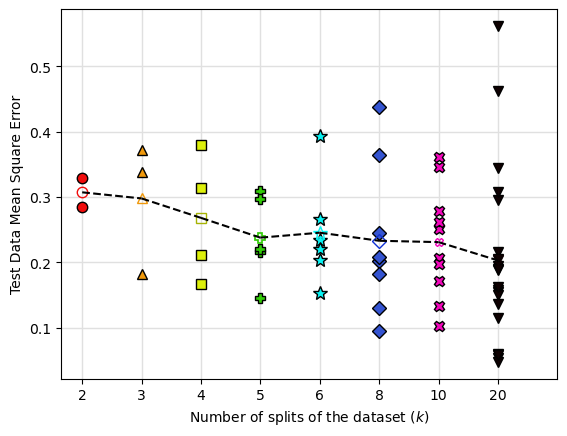

<Figure size 5940x5400 with 0 Axes>

In [14]:
#https://g.co/kgs/kL9zrcF Color picker

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

ax1=plt.subplot(1, 1, 1)

space_array = list(range(0,len(k_values)))

#2-fold CV
ax1.plot(info_array[0:2,0], info_array[0:2,1],marker='o',ls='None',mec='k',mfc='#f00c0c',markersize=7.5, label='2-fold CV')
ax1.plot(space_array[0], mse_avg[0],marker='o',ls='None',mec='#f00c0c',mfc='None',markersize=7.5)

#3-fold CV
ax1.plot(info_array[2:5,0], info_array[2:5,1],marker='^',ls='None',mec='k',mfc='#f0990c',markersize=7.5, label='3-fold CV')
ax1.plot(space_array[1], mse_avg[1],marker='^',ls='None',mec='#f0990c',mfc='None',markersize=7.5)
ax1.plot([space_array[0],space_array[1]],[mse_avg[0], mse_avg[1]], '--k')

#4-fold CV
ax1.plot(info_array[5:9,0], info_array[5:9,1],marker='s',ls='None',mec='k',mfc='#ddf00c',markersize=7.5, label='4-fold CV')
ax1.plot(space_array[2], mse_avg[2],marker='s',ls='None',mec='#a7b305',mfc='None',markersize=7.5)
ax1.plot([space_array[1],space_array[2]],[mse_avg[1], mse_avg[2]], '--k')

#5-fold CV
ax1.plot(info_array[9:14,0], info_array[9:14,1],marker='P',ls='None',mec='k',mfc='#32cc08', markersize=7.5, label='5-fold CV')
ax1.plot(space_array[3], mse_avg[3],marker='P',ls='None',mec='#32cc08',mfc='None', markersize=7.5, markeredgewidth=1.25)
ax1.plot([space_array[2],space_array[3]],[mse_avg[2], mse_avg[3]], '--k')

# #6-fold CV
ax1.plot(info_array[14:20,0], info_array[14:20,1],marker='*',ls='None',mec='k',mfc='#07f2f2', markersize=10, label='6-fold CV')
ax1.plot(space_array[4], mse_avg[4],marker='*',ls='None',mec='#07f2f2',mfc='None',markeredgewidth=1,markersize=10)
ax1.plot([space_array[3],space_array[4]],[mse_avg[3], mse_avg[4]], '--k')

# #8-fold CV
ax1.plot(info_array[20:28,0], info_array[20:28,1],marker='D',ls='None',mec='k',mfc='#3454D1',markersize=7.5, label='8-fold CV')
ax1.plot(space_array[5], mse_avg[5],marker='D',ls='None',mec='#0f30d4',mfc='None',markersize=7.5)
ax1.plot([space_array[4],space_array[5]],[mse_avg[4], mse_avg[5]], '--k')

#10-fold CV
ax1.plot(info_array[28:38,0], info_array[28:38,1],marker='X',ls='None',mec='k',mfc='#f207bb',markersize=7.5, label='10-fold CV')
ax1.plot(space_array[6], mse_avg[6],marker='X',ls='None',mec='#f207bb',mfc='None')
ax1.plot([space_array[5],space_array[6]],[mse_avg[5], mse_avg[6]], '--k')

#20-fold CV
ax1.plot(info_array[38:58,0], info_array[38:58,1],marker='v',ls='None',mec='k',mfc='#0f0102',markersize=7.5, label='20-fold CV')
ax1.plot(space_array[7], mse_avg[7],marker='v',ls='None',mec='#0f0102',mfc='None',markersize=7.5)
ax1.plot([space_array[6],space_array[7]],[mse_avg[6], mse_avg[7]], '--k')


plt.xticks(np.arange(0, 10, step=2))

ax1.set_xticks(space_array)
ax1.set_xticklabels((2,3,4,5,6,8,10,20))

ax1.set_xlabel('Number of splits of the dataset ($k$)')
ax1.set_ylabel('Test Data Mean Square Error')

#ax1.grid()
#plt.gca().set_aspect('equal', adjustable='box')

## Figure property 
figure(figsize=(3.3, 3), dpi=1800) # for figsize: width, height in inches
#ax1.autolayout : true # for labels not being cut out

## Axes
ax1.titlesize : 8
ax1.labelsize : 8
#ax1.formatter.limits : -5

## Grid
ax1.grid(True, color='#e0e0e0', which='both', linewidth=1)


Text(0, 0.5, 'Test Data Root Mean Square Error')

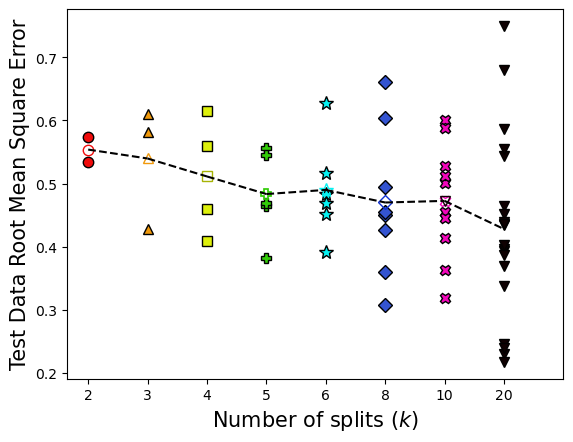

In [15]:
ax1=plt.subplot(1, 1, 1)

space_array = list(range(0,len(k_values)))

#2-fold CV
ax1.plot(info_array[0:2,0], info_array[0:2,2],marker='o',ls='None',mec='k',mfc='#f00c0c', markersize=7.5)
ax1.plot(space_array[0], rmse_avg[0],marker='o',ls='None',mec='#f00c0c',mfc='None', markersize=7.5)

#3-fold CV
ax1.plot(info_array[2:5,0], info_array[2:5,2],marker='^',ls='None',mec='k',mfc='#f0990c', markersize=7.5)
ax1.plot(space_array[1], rmse_avg[1],marker='^',ls='None',mec='#f0990c',mfc='None', markersize=7.5)
ax1.plot([space_array[0],space_array[1]],[rmse_avg[0], rmse_avg[1]], '--k')

#4-fold CV
ax1.plot(info_array[5:9,0], info_array[5:9,2],marker='s',ls='None',mec='k',mfc='#ddf00c', markersize=7.5)
ax1.plot(space_array[2], rmse_avg[2],marker='s',ls='None',mec='#a7b305',mfc='None', markersize=7.5)
ax1.plot([space_array[1],space_array[2]],[rmse_avg[1], rmse_avg[2]], '--k')

#5-fold CV
ax1.plot(info_array[9:14,0], info_array[9:14,2],marker='P',ls='None',mec='k',mfc='#32cc08', markersize=7.5)
ax1.plot(space_array[3], rmse_avg[3],marker='P',ls='None',mec='#32cc08',mfc='None', markersize=7.5, markeredgewidth=1.25)
ax1.plot([space_array[2],space_array[3]],[rmse_avg[2], rmse_avg[3]], '--k')

# #6-fold CV
ax1.plot(info_array[14:20,0], info_array[14:20,2],marker='*',ls='None',mec='k',mfc='#07f2f2', markersize=10)
ax1.plot(space_array[4], rmse_avg[4],marker='*',ls='None',mec='#07f2f2',mfc='None', markersize=10)
ax1.plot([space_array[3],space_array[4]],[rmse_avg[3], rmse_avg[4]], '--k')

# #8-fold CV
ax1.plot(info_array[20:28,0], info_array[20:28,2],marker='D',ls='None',mec='k',mfc='#3454D1',markersize=7.5)
ax1.plot(space_array[5], rmse_avg[5],marker='D',ls='None',mec='#0f30d4',mfc='None',markersize=7.5)
ax1.plot([space_array[4],space_array[5]],[rmse_avg[4], rmse_avg[5]], '--k')

#10-fold CV
ax1.plot(info_array[28:38,0], info_array[28:38,2],marker='X',ls='None',mec='k',mfc='#f207bb', markersize=7.5)
ax1.plot(space_array[6], rmse_avg[6],marker='X',ls='None',mec='#f207bb',mfc='None', markersize=7.5)
ax1.plot([space_array[5],space_array[6]],[rmse_avg[5], rmse_avg[6]], '--k', markersize=7.5)

#20-fold CV
ax1.plot(info_array[38:58,0], info_array[38:58,2],marker='v',ls='None',mec='k',mfc='#0f0102', markersize=7.5)
ax1.plot(space_array[6], rmse_avg[6],marker='v',ls='None',mec='#0f0102',mfc='None', markersize=7.5)
ax1.plot([space_array[6],space_array[7]],[rmse_avg[6], rmse_avg[7]], '--k')


plt.xticks(np.arange(0, 10, step=2))

ax1.set_xticks(space_array)
ax1.set_xticklabels((2,3,4,5,6,8,10,20))

#ax1.set_yticks(np.linspace(0.2, 0.8, 7))

ax1.set_xlabel('Number of splits ($k$)',size=15)
ax1.set_ylabel('Test Data Root Mean Square Error',size=15)


C:\Users\vikra\AppData\Local\Temp\ipykernel_24056\3123961096.py:11: RuntimeWarning: divide by zero encountered in log
  ax0.plot([x_space[0],x_space[0]],np.log(info_array[0:2, :2]),marker='o', color= 'r', ls='None',alpha=alpha)


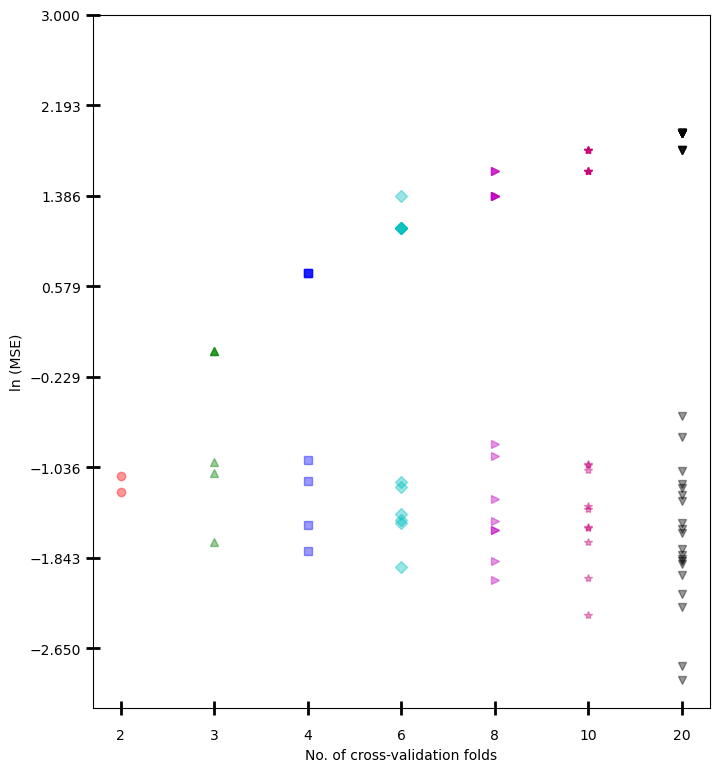

In [16]:
fig = plt.figure(figsize=(10,9))
ax0 = fig.add_subplot(1, 1, 1, aspect=1.4)
ax0.set_xlabel('No. of cross-validation folds')
ax0.set_ylabel('ln (MSE)')
 
x_space = np.array(np.linspace(1,6,7))
alpha = 0.4
alpha2 = 1
 
#plt RMSE values for all models generated in each fold
ax0.plot([x_space[0],x_space[0]],np.log(info_array[0:2, :2]),marker='o', color= 'r', ls='None',alpha=alpha)
ax0.plot([x_space[1],x_space[1],x_space[1]],np.log(info_array[2:5, :2]),marker='^', color= 'g',ls='None',alpha=alpha)
ax0.plot([x_space[2],x_space[2],x_space[2],x_space[2]],np.log(info_array[5:9, :2]),marker='s', color= 'b',ls='None',alpha=alpha)
ax0.plot([x_space[3],x_space[3],x_space[3],x_space[3],x_space[3], x_space[3]],np.log(info_array[9:15, :2]),marker='D', color= 'c',ls='None',alpha=alpha)
ax0.plot([x_space[4],x_space[4],x_space[4],x_space[4],x_space[4],x_space[4],x_space[4],x_space[4]],np.log(info_array[15:23, :2]),marker='>', color= 'm',ls='None',alpha=alpha)
ax0.plot([x_space[5],x_space[5],x_space[5],x_space[5],x_space[5],x_space[5],x_space[5],x_space[5],x_space[5],x_space[5]],np.log(info_array[23:33, :2]),marker='*', color= '#c90076',ls='None',alpha=alpha)
ax0.plot([x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6],x_space[6]],np.log(info_array[33:53, :2]),marker='v', color= 'k',ls='None',alpha=alpha)

# ax0.plot(x_space[0],np.log(MSE_mean[0]),marker='o', mec= 'r', color= 'None', ls='None',alpha=alpha2)
# ax0.plot(x_space[1],np.log(MSE_mean[1]),marker='^', mec= 'g', color= 'None', ls='None',alpha=alpha2)
# ax0.plot(x_space[2],np.log(MSE_mean[2]),marker='s', mec= 'b', color= 'None', ls='None',alpha=alpha2)
# ax0.plot(x_space[3],np.log(MSE_mean[3]),marker='D', mec= 'c', color= 'None', ls='None',alpha=alpha2)
# ax0.plot(x_space[4],np.log(MSE_mean[4]),marker='>', mec= 'm', color= 'None', ls='None',alpha=alpha2)
# ax0.plot(x_space[5],np.log(MSE_mean[5]),marker='*', mec= '#c90076', color= 'None', ls='None',alpha=alpha2)
# ax0.plot(x_space[6],np.log(MSE_mean[6]),marker='v', mec= 'k', color= 'None', ls='None',alpha=alpha2)
# ax0.plot(x_space[7],np.log(MSE_mean[7]),marker='<', mec= '#ff9f00', color= 'None', ls='None',alpha=alpha2)
# ax0.plot(x_space[8],np.log(MSE_mean[8]),marker='p', mec= '#95BDFF', color= 'None', ls='None',alpha=alpha2)
 
# ax0.plot(x_space,np.log(MSE_mean), '--k')
 
ax0.set_xticks(x_space)
ax0.set_xticklabels((2,3,4,6,8,10,20))
ax0.set_yticks(np.linspace(3, -2.65, 8))
ax0.tick_params(axis='x', which='major', pad=10)
ax0.tick_params(which='major', length=10, width=2, direction='inout')
 
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("ln(MSE)_vs_k_in_cross_validation.pdf")
plt.show()

In [17]:
np.max(np.log(info_array))

C:\Users\vikra\AppData\Local\Temp\ipykernel_24056\4078720842.py:1: RuntimeWarning: divide by zero encountered in log
  np.max(np.log(info_array))


1.9459101490553132

In [18]:
info_array[14:20,2]

array([0.48423916, 0.51652344, 0.46937946, 0.6271504 , 0.45113026,
       0.39165556])

In [19]:
test_mse_avg = np.average(mse_avg)
test_mse_avg

0.2528247408876961

In [20]:
mse_avg

array([0.30716632, 0.29778153, 0.26802618, 0.23771487, 0.24530522,
       0.23294756, 0.23085479, 0.20280146])